<a href="https://colab.research.google.com/github/Divdev01/CVND_Exercises/blob/master/Assignment_2_CNN_Tranfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np

In [2]:
#Downloading the flower_photos dataset that has 3700 images and 5 subdirectories

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [3]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [5]:
list(data_dir.glob("*/"))                

[PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/sunflowers')]

In [7]:
#import Python Image Library - helpful for loading images from files and creating new images as well

import PIL

In [8]:
data_dir.glob('roses/*')

<generator object Path.glob at 0x7f76b32d5a50>

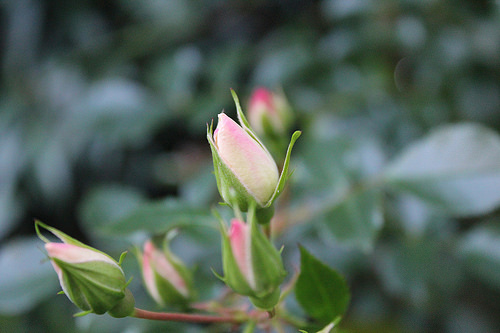

In [9]:
#opening one sample image from rose class

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[3]))

In [10]:
#set useful variables for batch and image size
batch_size = 32
img_height =150
img_width = 150

In [11]:

#Used image_dataset_from_directory utility for loading the data from disk to tf.data.dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2753 files for training.


In [12]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 917 files for validation.


In [13]:
# create a list for storing class names

class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [14]:
#Check image count

image_count = len(list(data_dir.glob('*/*.jpg')))
print('Number of images in the available in dataset: ', image_count)
class_len=[]

#Check whether each class have balanced data
for cls in class_names:
  class_len.append(len(list(data_dir.glob(str(cls)+'/*'))))
print("number of images in each class: ", class_len)





Number of images in the available in dataset:  3670
number of images in each class:  [633, 898, 641, 699, 799]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


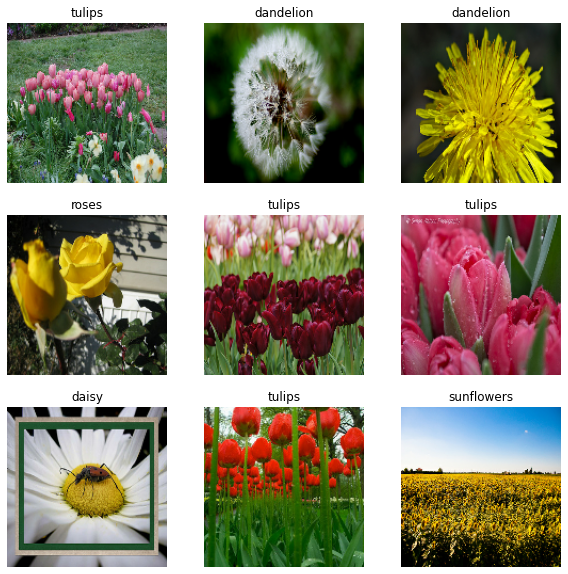

In [15]:
#Visualize randomly 9 pictures at a time


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [16]:
# move 25% of validation set to a test set.
val_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(val_batches // 2)
valid_ds = valid_ds.skip(val_batches // 2)


In [17]:
# buffered prefetching to load images from disk without having I/O become blocking

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


**Image Augmentation**

In the given dataset only 3670 images are available. It may be hard to generalize well to the new data. Augmentation provide more images by manipulating the image in various ways. 

Here we use ImageDataGenerator() instance for performing various transformations on Images


In [23]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 150,150 #180, 180
# img_height =180
# img_width = 180

base_model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_h, image_w, 3))
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [25]:
# Freezing all the layers of base model (VGG)
for layer in base_model.layers:
    layer.trainable = False

In [26]:
# Sanity check - frozen  layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [27]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [30]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, InputLayer
def create_model_1():
  model = keras.models.Sequential([
                                   base_model,
                                  # preprocess_input,
                                #   resize_and_rescale,

                                   data_augmentation,

                                   # Flatten(name='flatten'),
                                   # layers.Dense(256, activation='relu'),
                                   Flatten(name='flatten'),
                                   Dense(256, activation='relu', name='new_fc1'),
                                   # Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
                                   Dense(5,activation='softmax')
                                   ])
  return model
  

In [31]:
model_1 = create_model_1()

In [257]:
# from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
# model_1 = keras.models.Sequential([
#     base_model,
#     # Flatten(name='flatten'),
#     # layers.Dense(256, activation='relu'),
#     Flatten(name='flatten'),
#     Dense(256, activation='relu', name='new_fc1'),
#    # Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
#     Dense(5,activation='softmax')
    
# ])

In [32]:
model_1.layers

In [33]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
from keras import optimizers

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [35]:
history_1 = model_1.fit(train_ds, validation_data=valid_ds, epochs=10)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


87/87 [==============================] - 53s 212ms/step - loss: 4.5337 - accuracy: 0.6146 - val_loss: 2.8970 - val_accuracy: 0.7058
Epoch 2/10
87/87 [==============================] - 15s 167ms/step - loss: 1.7947 - accuracy: 0.7853 - val_loss: 2.4610 - val_accuracy: 0.7420
Epoch 3/10
87/87 [==============================] - 15s 167ms/step - loss: 1.4164 - accuracy: 0.8057 - val_loss: 2.4072 - val_accuracy: 0.7335
Epoch 4/10
87/87 [==============================] - 15s 168ms/step - loss: 1.0276 - accuracy: 0.8238 - val_loss: 2.4582 - val_accuracy: 0.7569
Epoch 5/10
87/87 [==============================] - 15s 170ms/step - loss: 0.6954 - accuracy: 0.8674 - val_loss: 2.1750 - val_accuracy: 0.7910
Epoch 6/10
87/87 [==============================] - 15s 170ms/step - loss: 0.6115 - accuracy: 0.8845 - val_loss: 1.9188 - val_accuracy: 0.7740
Epoch 7/10
87/87 [==============================] - 15s 171ms/step - loss: 0.4852 - accuracy: 0.9005 - val_loss: 1.8696 - val_accuracy: 0.7932
Epoch 8/10

In [36]:
#Learning curve
def plot_learning_curve (history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

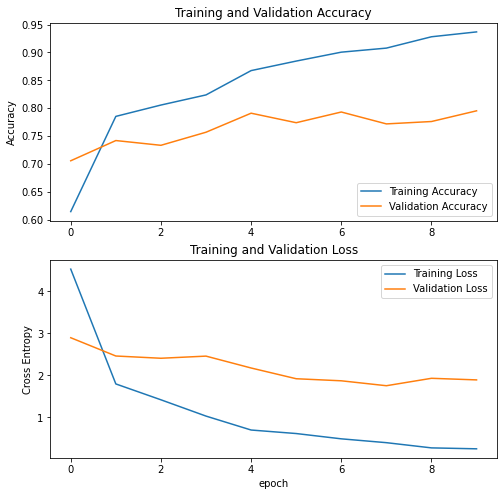

In [37]:
plot_learning_curve(history_1)

**PART 2 - UNFREEZE LAST BLOCK OF VGG**

In [43]:


#tf.keras.backend.clear_session()
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
# Unfreeze block 5 layers
for layer in base_model.layers[15:]:
    layer.trainable = True

In [45]:
#Sanity check for trainable layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [47]:
#Modeule for creating model 2 
def create_model_2():
  model = keras.models.Sequential([
      base_model,
      # Flatten(name='flatten'),
      # layers.Dense(256, activation='relu'),
      Flatten(name='flatten'),
      Dense(256, activation='relu', name='m2_new_fc1'),
    # Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
      Dense(5,activation='softmax')
      ])
  return model

In [48]:
model_2 = create_model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
m2_new_fc1 (Dense)           (None, 256)               2097408   
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 9,178,117
Non-trainable params: 7,635,264
_________________________________________________________________


In [49]:
model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=["accuracy"])

In [59]:
history_2 = model_2.fit(train_ds, validation_data=valid_ds, epochs=25)


Epoch 1/25
87/87 [==============================] - 17s 195ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.3679 - val_accuracy: 0.8998
Epoch 2/25
87/87 [==============================] - 17s 193ms/step - loss: 9.9875e-04 - accuracy: 1.0000 - val_loss: 0.4324 - val_accuracy: 0.8870
Epoch 3/25
87/87 [==============================] - 17s 192ms/step - loss: 3.9485e-04 - accuracy: 1.0000 - val_loss: 0.5025 - val_accuracy: 0.8891
Epoch 4/25
87/87 [==============================] - 17s 194ms/step - loss: 2.9610e-04 - accuracy: 1.0000 - val_loss: 0.5691 - val_accuracy: 0.8742
Epoch 5/25
87/87 [==============================] - 17s 194ms/step - loss: 2.3683e-04 - accuracy: 1.0000 - val_loss: 0.4970 - val_accuracy: 0.8934
Epoch 6/25
87/87 [==============================] - 17s 195ms/step - loss: 1.9495e-04 - accuracy: 1.0000 - val_loss: 0.4622 - val_accuracy: 0.8827
Epoch 7/25
87/87 [==============================] - 17s 193ms/step - loss: 1.6363e-04 - accuracy: 1.0000 - val_loss: 0.458

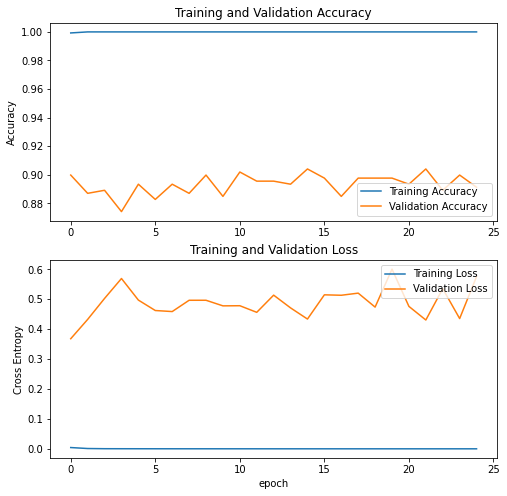

In [61]:
plot_learning_curve(history_2)

**PART 3 - UNFREEZE All LAYERS OF VGG**




In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
for layer in base_model.layers:
    layer.trainable = True

In [54]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [55]:
#Modeule for creating model 3 
def create_model_3():
  model = keras.models.Sequential([
      base_model,
      # Flatten(name='flatten'),
      # layers.Dense(256, activation='relu'),
      Flatten(name='flatten'),
      Dense(256, activation='relu', name='m3_new_fc1'),
    # Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
      Dense(5,activation='softmax')
      ])
  return model

In [56]:
model_3 = create_model_3()

In [57]:
model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=["accuracy"])

In [58]:
history_3 = model_3.fit(train_ds, validation_data=valid_ds, epochs=25)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


87/87 [==============================] - 43s 454ms/step - loss: 0.6418 - accuracy: 0.7792 - val_loss: 0.7081 - val_accuracy: 0.7719
Epoch 2/10
87/87 [==============================] - 39s 448ms/step - loss: 0.3030 - accuracy: 0.8859 - val_loss: 0.5647 - val_accuracy: 0.8188
Epoch 3/10
87/87 [==============================] - 39s 448ms/step - loss: 0.1751 - accuracy: 0.9393 - val_loss: 0.5804 - val_accuracy: 0.8337
Epoch 4/10
87/87 [==============================] - 39s 449ms/step - loss: 0.1547 - accuracy: 0.9459 - val_loss: 0.4418 - val_accuracy: 0.8380
Epoch 5/10
87/87 [==============================] - 39s 448ms/step - loss: 0.3192 - accuracy: 0.8845 - val_loss: 0.5296 - val_accuracy: 0.8550
Epoch 6/10
87/87 [==============================] - 39s 448ms/step - loss: 0.1193 - accuracy: 0.9575 - val_loss: 0.5203 - val_accuracy: 0.8614
Epoch 7/10
87/87 [==============================] - 39s 447ms/step - loss: 0.0676 - accuracy: 0.9789 - val_loss: 0.5092 - val_accuracy: 0.8891
Epoch 8/10

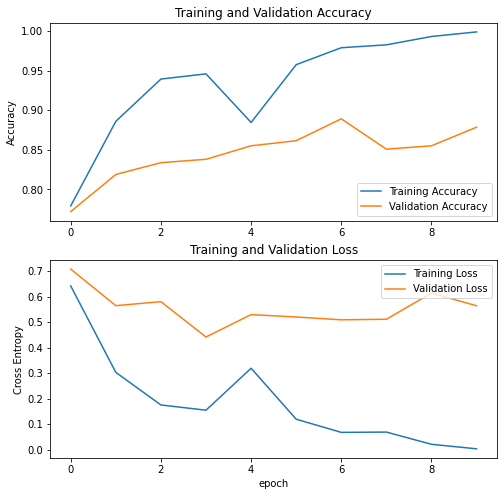

In [60]:
plot_learning_curve(history_3)

References

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

